In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_XCRD
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [7]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_XCRD
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.05

klin =0

nband = 520

ng =8

ng_refs = (/ 3 , 2 , 3 /) 

nref =3

nv = 20

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294.0

vstar = 1380

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66/

data wgt
     &     /0.55 , 0.55 , 0.85 , 0.85,
     &     0.85 , 0.0 , 0.3 , 0.55/

atmosphere_profiles/mls75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

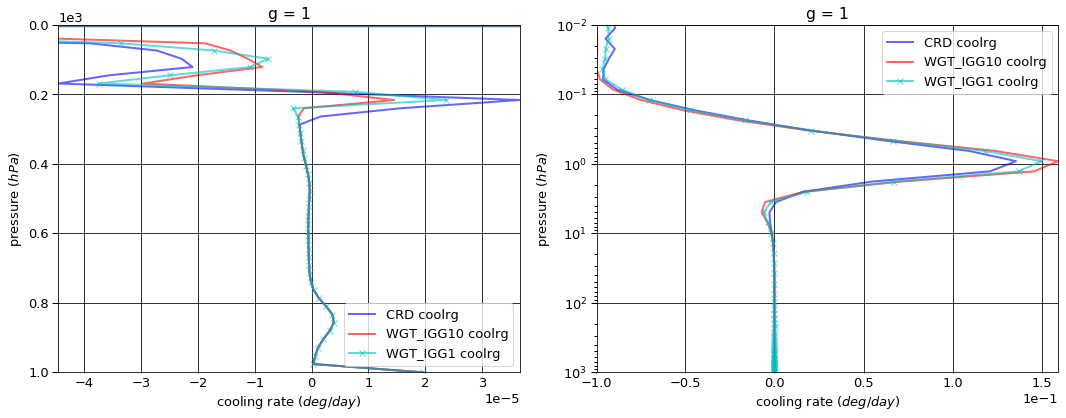

# Figure: cooling rate g-group 2

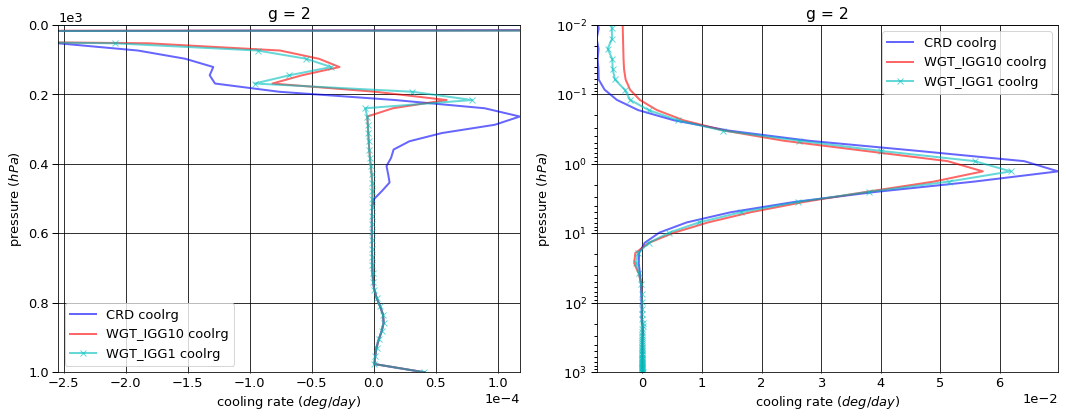

# Figure: cooling rate g-group 3

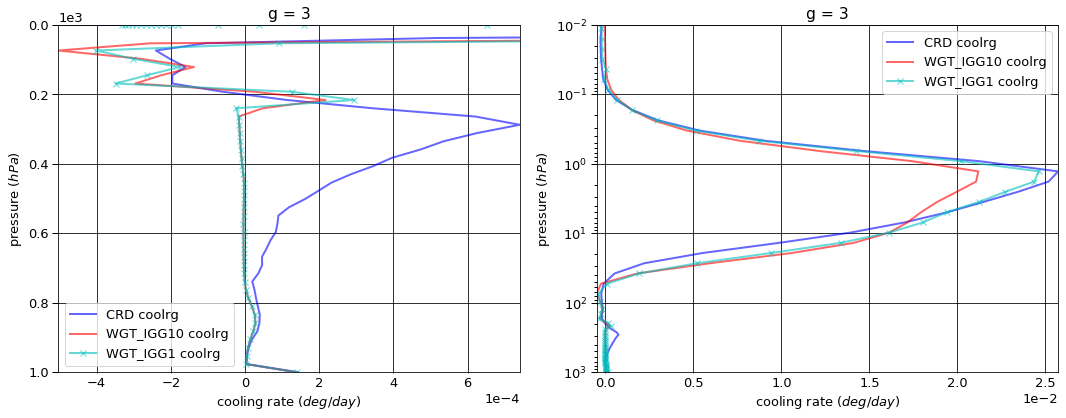

# Figure: cooling rate g-group 4

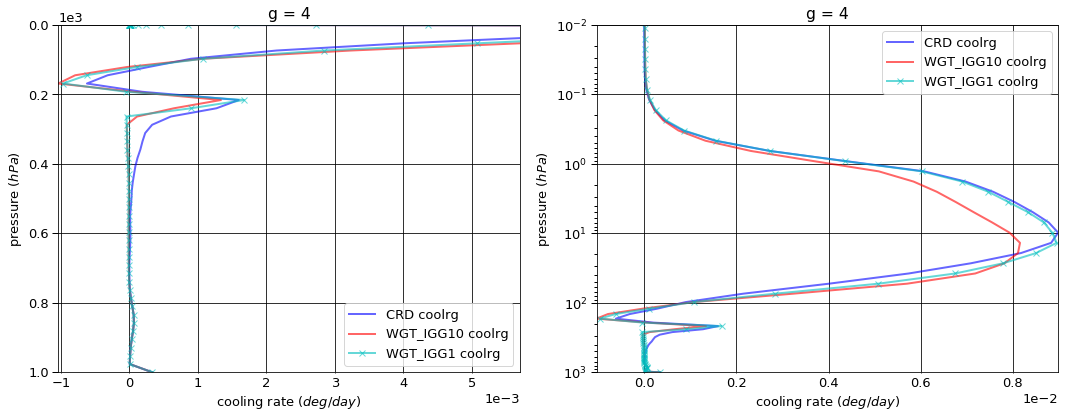

# Figure: cooling rate g-group 5

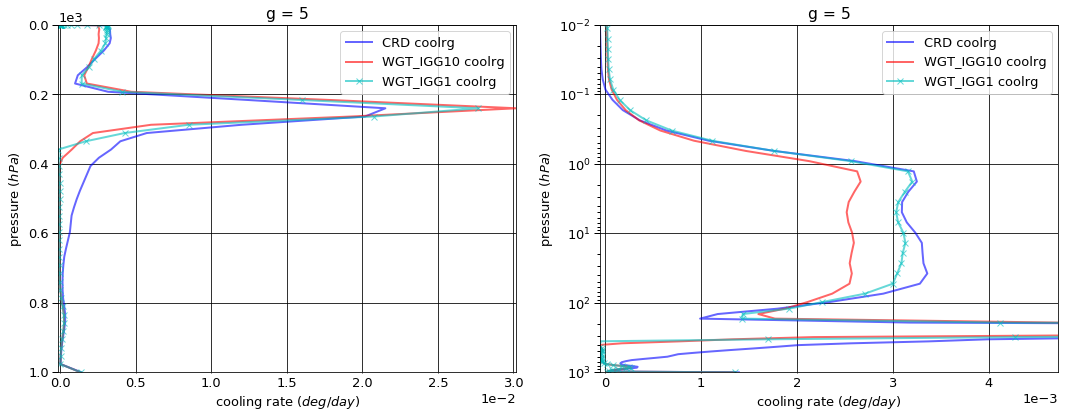

# Figure: cooling rate g-group 6

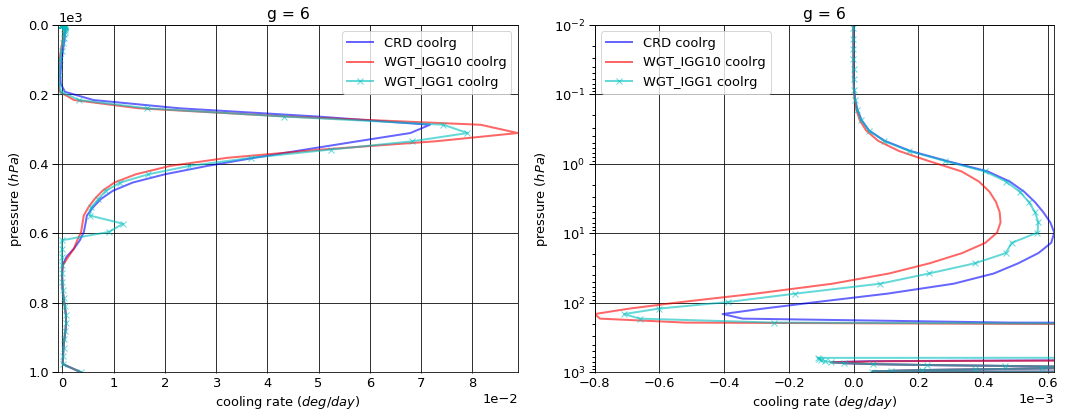

# Figure: cooling rate g-group 7

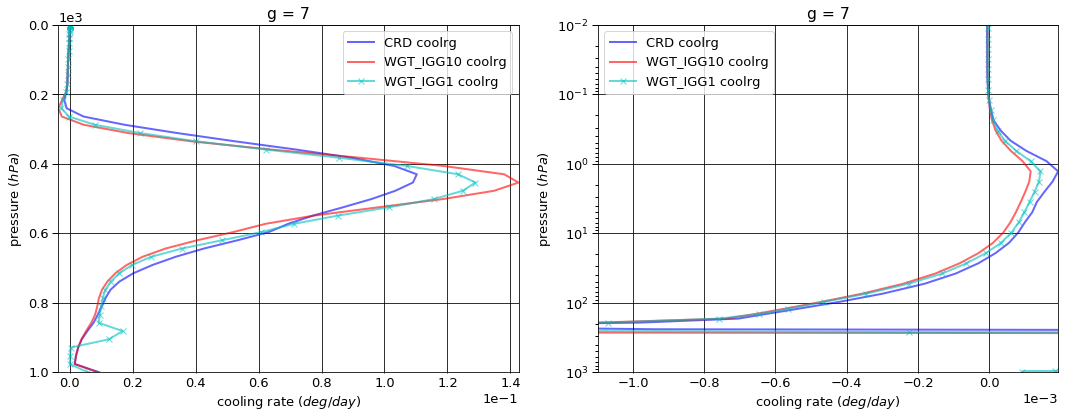

# Figure: cooling rate g-group 8

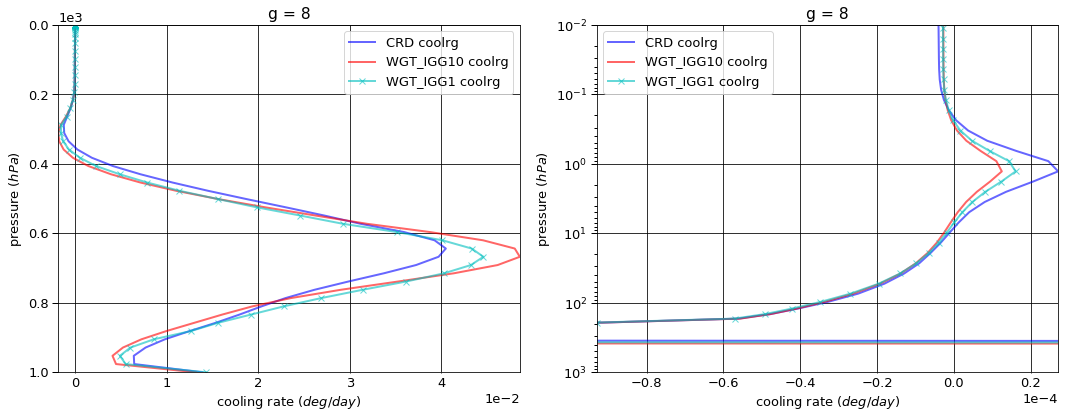

# Figure: cooling rate g-group total

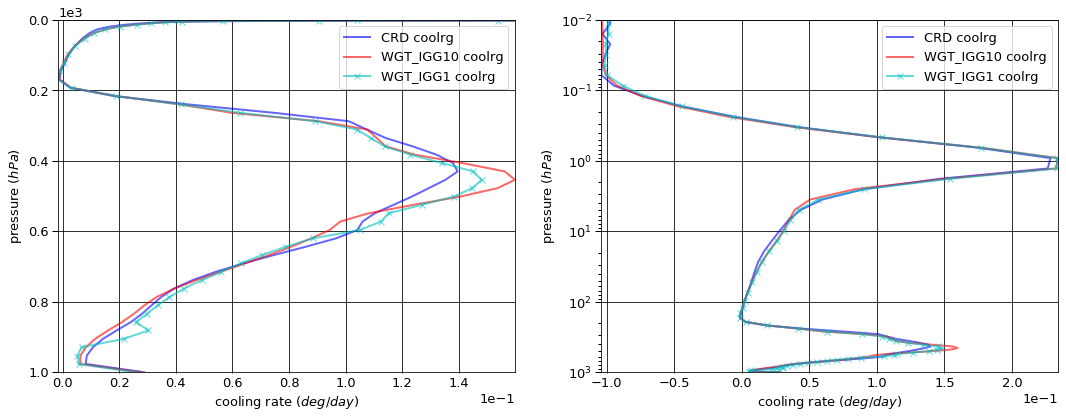

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.015787   0.000000 -0.015787
  1013.0   76     -0.047637   0.047582 -0.000055
2 0.0      1      -0.022709   0.000000 -0.022709
  1013.0   76     -0.096506   0.096391 -0.000115
3 0.0      1      -0.050972   0.000000 -0.050972
  1013.0   76     -0.341811   0.341412 -0.000399
4 0.0      1      -0.070096   0.000000 -0.070096
  1013.0   76     -0.806497   0.805557 -0.000940
5 0.0      1      -0.338149   0.000000 -0.338149
  1013.0   76     -3.284543   3.280635 -0.003909
6 0.0      1      -1.344306   0.000000 -1.344306
  1013.0   76     -8.746014   8.735830 -0.010184
7 0.0      1      -3.828456   0.000000 -3.828456
  1013.0   76    -13.959553  13.934854 -0.024698
8 0.0      1      -1.599986   0.000000 -1.599986
  1013.0   76     -3.447054   3.394522 -0.052532


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.017806   0.000000 -0.017806
  1013.0   76     -0.047637   0.047582 -0.000055
2 0.0      1      -0.022731   0.000000 -0.022731
  1013.0   76     -0.096506   0.096391 -0.000115
3 0.0      1      -0.044810   0.000000 -0.044810
  1013.0   76     -0.341811   0.341419 -0.000392
4 0.0      1      -0.065830   0.000000 -0.065830
  1013.0   76     -0.806497   0.805557 -0.000940
5 0.0      1      -0.288497   0.000000 -0.288497
  1013.0   76     -3.284543   3.280732 -0.003812
6 0.0      1      -1.344934   0.000000 -1.344934
  1013.0   76     -8.746014   8.735830 -0.010184
7 0.0      1      -3.837881   0.000000 -3.837881
  1013.0   76    -13.959553  13.936432 -0.023121
8 0.0      1      -1.609054   0.000000 -1.609054
  1013.0   76     -3.447054   3.407730 -0.039325


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.017319   0.000000 -0.017319
  1013.0   76     -0.047637   0.047582 -0.000055
2 0.0      1      -0.022784   0.000000 -0.022784
  1013.0   76     -0.096506   0.096391 -0.000115
3 0.0      1      -0.045469   0.000000 -0.045469
  1013.0   76     -0.341811   0.341419 -0.000392
4 0.0      1      -0.066837   0.000000 -0.066837
  1013.0   76     -0.806497   0.805557 -0.000940
5 0.0      1      -0.292909   0.000000 -0.292909
  1013.0   76     -3.284543   3.280732 -0.003812
6 0.0      1      -1.358606   0.000000 -1.358606
  1013.0   76     -8.746014   8.735830 -0.010184
7 0.0      1      -3.883609   0.000000 -3.883609
  1013.0   76    -13.959553  13.943439 -0.016114
8 0.0      1      -1.622521   0.000000 -1.622521
  1013.0   76     -3.447054   3.401653 -0.045401


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -2.019775e-03  0.000000e+00 -2.019775e-03
  1013.0   76     0.000000e+00  0.000000e+00  6.776264e-21
2 0.0      1     -2.209500e-05  0.000000e+00 -2.209500e-05
  1013.0   76     0.000000e+00 -1.387779e-17  1.355253e-20
3 0.0      1      6.161689e-03  0.000000e+00  6.161689e-03
  1013.0   76    -5.551115e-17  6.700000e-06  6.694660e-06
4 0.0      1      4.266098e-03  0.000000e+00  4.266098e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5 0.0      1      4.965204e-02  0.000000e+00  4.965204e-02
  1013.0   76     0.000000e+00  9.720000e-05  9.716250e-05
6 0.0      1     -6.280000e-04  0.000000e+00 -6.280000e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7 0.0      1     -9.425200e-03  0.000000e+00 -9.425200e-03
  1013.0   76     0.000000e+00  1.578000e-03  1.577213e-03
8 0.0      1     -9.068000e-03  0.000000e+00 -9.068000e-03
  1013.0   76     0.000000e+00  1.320740e-02  1.320749e-02


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -1.532480e-03  0.000000e+00 -1.532480e-03
  1013.0   76     0.000000e+00  0.000000e+00  6.776264e-21
2 0.0      1     -7.447600e-05  0.000000e+00 -7.447600e-05
  1013.0   76     0.000000e+00 -1.387779e-17  1.355253e-20
3 0.0      1      5.502697e-03  0.000000e+00  5.502697e-03
  1013.0   76    -5.551115e-17  6.700000e-06  6.694660e-06
4 0.0      1      3.258274e-03  0.000000e+00  3.258274e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5 0.0      1      4.523999e-02  0.000000e+00  4.523999e-02
  1013.0   76     0.000000e+00  9.720000e-05  9.716250e-05
6 0.0      1     -1.429940e-02  0.000000e+00 -1.429940e-02
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7 0.0      1     -5.515320e-02  0.000000e+00 -5.515320e-02
  1013.0   76     0.000000e+00  8.585000e-03  8.584482e-03
8 0.0      1     -2.253500e-02  0.000000e+00 -2.253500e-02
  1013.0   76     0.000000e+00  7.130700e-03  7.130774e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -9.725487e-02
  1001.112500 75     1.952493e-05
2 0.000312    1     -7.678360e-03
  1001.112500 75     4.097418e-05
3 0.000312    1     -4.034426e-04
  1001.112500 75     1.433637e-04
4 0.000312    1     -1.265024e-05
  1001.112500 75     3.351579e-04
5 0.000312    1     -6.892803e-05
  1001.112500 75     1.397628e-03
6 0.000312    1     -5.541192e-07
  1001.112500 75     3.632037e-03
7 0.000312    1     -6.426066e-06
  1001.112500 75     9.433421e-03
8 0.000312    1     -4.174925e-06
  1001.112500 75     1.389556e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.049149e-01
  1001.112500 75     1.952493e-05
2 0.000312    1     -3.579574e-03
  1001.112500 75     4.097418e-05
3 0.000312    1     -1.435754e-04
  1001.112500 75     1.399677e-04
4 0.000312    1      2.954385e-06
  1001.112500 75     3.351579e-04
5 0.000312    1      4.273941e-06
  1001.112500 75     1.359418e-03
6 0.000312    1     -5.635606e-07
  1001.112500 75     3.632037e-03
7 0.000312    1     -4.615045e-06
  1001.112500 75     8.943204e-03
8 0.000312    1     -2.777146e-06
  1001.112500 75     1.318944e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -9.823073e-02
  1001.112500 75     1.952493e-05
2 0.000312    1     -5.373724e-03
  1001.112500 75     4.097418e-05
3 0.000312    1     -3.309274e-04
  1001.112500 75     1.399677e-04
4 0.000312    1     -6.208363e-07
  1001.112500 75     3.351579e-04
5 0.000312    1      6.878497e-06
  1001.112500 75     1.359418e-03
6 0.000312    1     -5.220364e-07
  1001.112500 75     3.632037e-03
7 0.000312    1     -4.695037e-06
  1001.112500 75     5.747260e-03
8 0.000312    1     -2.900170e-06
  1001.112500 75     1.427609e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -7.660003e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      4.098786e-03
  1001.112500 75     6.776264e-21
3 0.000312    1      2.598672e-04
  1001.112500 75    -3.395980e-06
4 0.000312    1      1.560462e-05
  1001.112500 75     0.000000e+00
5 0.000312    1      7.320197e-05
  1001.112500 75    -3.821030e-05
6 0.000312    1     -9.441410e-09
  1001.112500 75     0.000000e+00
7 0.000312    1      1.811021e-06
  1001.112500 75    -4.902169e-04
8 0.000312    1      1.397779e-06
  1001.112500 75    -7.061200e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -9.758660e-04
  1001.112500 75     0.000000e+00
2 0.000312    1      2.304636e-03
  1001.112500 75     6.776264e-21
3 0.000312    1      7.251519e-05
  1001.112500 75    -3.395980e-06
4 0.000312    1      1.202940e-05
  1001.112500 75     0.000000e+00
5 0.000312    1      7.580653e-05
  1001.112500 75    -3.821030e-05
6 0.000312    1      3.208278e-08
  1001.112500 75     0.000000e+00
7 0.000312    1      1.731029e-06
  1001.112500 75    -3.686161e-03
8 0.000312    1      1.274755e-06
  1001.112500 75     3.805290e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.270460,0.000000,-7.270460
1013.0,76,-30.729617,30.636784,-0.092832



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.231543,0.000000,-7.231543
1013.0,76,-30.729617,30.651673,-0.077943



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.310054,0.000000,-7.310054
1013.0,76,-30.729617,30.652603,-0.077013



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.038917,0.000000,0.038917
1013.0,76,0.000000,0.014889,0.014889



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.039594,0.00000,-0.039594
1013.0,76,0.000000,0.01582,0.015819


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.105429
1001.112500,75,0.028898



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.108639
1001.112500,75,0.027660



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.103937
1001.112500,75,0.025550



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.003209
1001.112500,75,-0.001238



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001492
1001.112500,75,-0.003347


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001442,0.001575
2,0.003462,0.003033
3,0.010096,0.011291
4,0.025385,0.026090
5,0.102019,0.106897
6,0.276250,0.283337
7,0.439808,0.458804
8,0.141538,0.108972


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.317342e-18
2,1.018542e-19
3,7.875162e-21
4,6.051264e-21
5,4.686019e-22
6,1.797034e-21
7,1.398978e-22
8,1.089095e-23


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.317342e-18,NaN,0.001442,0.001575,0.001442,0.001575,1.0
2,1.018542e-19,0.077318,0.003462,0.003033,0.004904,0.004608,1.0
3,7.875162e-21,0.077318,0.010096,0.011291,0.015000,0.015899,1.0
4,6.051264e-21,0.768399,0.025385,0.026090,0.040385,0.041990,10.0
5,4.686019e-22,0.077439,0.102019,0.106897,0.142404,0.148887,10.0
6,1.797034e-21,3.834883,0.276250,0.283337,0.418654,0.432224,500.0
7,1.398978e-22,0.077849,0.439808,0.458804,0.858462,0.891028,500.0
8,1.089095e-23,0.077849,0.141538,0.108972,1.000000,1.000000,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     5.614662e-18  2.428477e-18   2.312009  3.560484e-04
      2 0.000312     1.624206e-19  9.291129e-20   1.748125  1.116815e-05
      3 0.000312     7.150383e-21  3.207969e-21   2.228944  5.585737e-07
      4 0.000312     1.758633e-22  1.328313e-22   1.323960  1.442702e-08
      5 0.000312     1.171697e-22  2.988443e-23   3.920760  8.863308e-09
      6 0.000312     5.758010e-25  5.583185e-25   1.031313  4.754704e-11
      7 0.000312     1.399746e-24  7.899442e-25   1.771955  8.285196e-11
      8 0.000312     1.852570e-24  2.273486e-25   8.148586  9.548440e-11
2     1 0.000750     5.621588e-18  2.433413e-18   2.310166  1.436184e-04
      2 0.000750     1.631471e-19  9.326939e-20   1.749203  4.517617e-06
      3 0.000750     7.182099e-21  3.224212e-21   2.227551  2.259944e-07
      4 0.000750     1.773686e-22  1.342102e-22   1.321573  5.861997e-09
      5 0.000750     1.173613e-22  3.002556e-23   3.908713  3.576336e-09
      6 0.000750     5.840833e-25  5.665191e-25   1.031004  1.943261e-11
      7 0.000750     1.404248e-24  7.931557e-25   1.770456  3.349511e-11
      8 0.000750     1.855933e-24  2.282354e-25   8.131662  3.853699e-11
3     1 0.001052     5.636320e-18  2.443892e-18   2.306288  2.020250e-04
      2 0.001052     1.646602e-19  9.398290e-20   1.752023  6.390919e-06
      3 0.001052     7.241701e-21  3.248575e-21   2.229193  3.195441e-07
      4 0.001052     1.792796e-22  1.358683e-22   1.319509  8.310881e-09
      5 0.001052     1.176782e-22  3.022758e-23   3.893073  5.029816e-09
      6 0.001052     5.932314e-25  5.755152e-25   1.030783  2.768477e-11
      7 0.001052     1.412876e-24  7.990110e-25   1.768281  4.729474e-11
      8 0.001052     1.863077e-24  2.300157e-25   8.099784  5.427127e-11
4     1 0.001476     5.651849e-18  2.454981e-18   2.302197  2.843324e-04
      2 0.001476     1.662776e-19  9.474887e-20   1.754929  9.049063e-06
      3 0.001476     7.306792e-21  3.276568e-21   2.230014  4.523030e-07
      4 0.001476     1.815379e-22  1.378607e-22   1.316821  1.180898e-08
      5 0.001476     1.180360e-22  3.045939e-23   3.875194  7.079163e-09
      6 0.001476     6.044025e-25  5.865232e-25   1.030483  3.958161e-11
      7 0.001476     1.422317e-24  8.054529e-25   1.765860  6.684487e-11
      8 0.001476     1.870759e-24  2.319309e-25   8.066019  7.648002e-11
5     1 0.002070     5.667317e-18  2.466074e-18   2.298113  4.000787e-04
      2 0.002070     1.679160e-19  9.553163e-20   1.757701  1.281073e-05
      3 0.002070     7.374823e-21  3.308098e-21   2.229324  6.403154e-07
      4 0.002070     1.841719e-22  1.402298e-22   1.313358  1.680868e-08
      5 0.002070     1.184270e-22  3.072008e-23   3.855035  9.964296e-09
      6 0.002070     6.179748e-25  5.999292e-25   1.030080  5.678558e-11
      7 0.002070     1.432189e-24  8.122562e-25   1.763223  9.448684e-11
      8 0.002070     1.878581e-24  2.338899e-25   8.031903  1.077605e-10
6     1 0.002904     5.682701e-18  2.477158e-18   2.294040  5.629912e-04
      2 0.002904     1.695780e-19  9.633483e-20   1.760297  1.813945e-05
      3 0.002904     7.446632e-21  3.344134e-21   2.226774  9.070165e-07
      4 0.002904     1.873233e-22  1.431202e-22   1.308853  2.399139e-08
      5 0.002904     1.188612e-22  3.102024e-23   3.831732  1.403228e-08
      6 0.002904     6.348797e-25  6.166646e-25   1.029538  8.187731e-11
      7 0.002904     1.442601e-24  8.195285e-25   1.760281  1.336309e-10
      8 0.002904     1.886547e-24  2.359025e-25   7.997150  1.518617e-10
7     1 0.004074     5.697990e-18  2.488233e-18   2.289975  7.922434e-04
      2 0.004074     1.712687e-19  9.716637e-20   1.762633  2.568844e-05
      3 0.004074     7.523470e-21  3.386395e-21   2.221675  1.285684e-06
      4 0.004074     1.911923e-22  1.467324e-22   1.303001  3.436793e-08
      5 0.004074     1.193536e-22  3.137581e-23   3.804000  1.977199e-08
      6 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
